In [1]:
#Setup EAST Tensorflow repository

import os
from os.path import exists, join, basename, splitext

# git_repo_url = 'https://github.com/argman/EAST.git'
# project_name = 'EAST'
# if not exists(project_name):
#   # clone and install
#   !git clone -q $git_repo_url 
#   #!cd $project_name && pip install -q -r requirements.txt
  
import sys
# sys.path.append(project_name)


In [2]:
#!pip3 install xmltodict
import pprint
import xmltodict
import shutil
import numpy as np
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

In [4]:
#Download weights

def download_from_google_drive(file_id, file_name):
  # download a file from the Google Drive link
  !rm -f ./cookie
  !curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=$file_id" > /dev/null
  confirm_text = !awk '/download/ {print $NF}' ./cookie
  confirm_text = confirm_text[0]
  !curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=$confirm_text&id=$file_id" -o $file_name
  

pretrained_model = 'east_icdar2015_resnet_v1_50_rbox'
if not exists(pretrained_model):
  # download the pretrained model
  pretrained_model_file_name = 'east_icdar2015_resnet_v1_50_rbox.zip'
  download_from_google_drive('0B3APw5BZJ67ETHNPaU9xUkVoV0U', pretrained_model_file_name)
  !unzip $pretrained_model_file_name

In [5]:
# !pip install tensorflow-gpu==1.15.5
# !pip install tensorflow-estimator==1.15.5

In [3]:
import cv2
import time
import math
import os
import numpy as np
#import tensorflow.compat.v1 as tf
import tensorflow as tf
print(tf.__version__)

tf.reset_default_graph()


1.15.2


In [4]:
# !mkdir Mavi_output
tf.app.flags.DEFINE_string('test_data_path', 'Mavi_subset', '')#/content/gdrive/My Drive/Galactica/Text_Recognition/Maavi_Data/data/', '')
tf.app.flags.DEFINE_string('gpu_list', '0', '')
tf.app.flags.DEFINE_string('checkpoint_path', 'east_icdar2015_resnet_v1_50_rbox/', '')
tf.app.flags.DEFINE_string('output_dir', 'Mavi_output','')#/content/gdrive/My Drive/Galactica/Text_Recognition/Maavi_Data/output/', '')

In [5]:
def extract_dims(ann):
  text = ""
  with open(ann) as file:
    doc = xmltodict.parse(file.read())
#     pprint.pprint(doc)
    if type(doc['SB']['info']['dir']) != list:
      text = doc['SB']['info']['dir']['text']['eng']
    else:
      for t in doc['SB']['info']['dir']:
         text = text + t['text']['eng'] + "/"
    Width = int(doc['SB']['dim']['Width'])
    Height = int(doc['SB']['dim']['Height'])
    x = int(doc['SB']['dim']['TopLeftX'])
    y = int(doc['SB']['dim']['TopLeftY'])
  return (x,y,Width,Height), text

#extract_dims("/content/gdrive/My Drive/Galactica/Text_Recognition/Maavi_Data/data/signboard_24/6.xml")

In [6]:
!module load compiler/gcc/6.5.0/compilervars #IMPORTANT 

resnet_v1_50/block1 (?, ?, ?, 256)
resnet_v1_50/block2 (?, ?, ?, 512)
resnet_v1_50/block3 (?, ?, ?, 1024)
resnet_v1_50/block4 (?, ?, ?, 2048)
Shape of f_0 (?, ?, ?, 2048)
Shape of f_1 (?, ?, ?, 512)
Shape of f_2 (?, ?, ?, 256)
Shape of f_3 (?, ?, ?, 64)
Shape of h_0 (?, ?, ?, 2048), g_0 (?, ?, ?, 2048)
Shape of h_1 (?, ?, ?, 128), g_1 (?, ?, ?, 128)
Shape of h_2 (?, ?, ?, 64), g_2 (?, ?, ?, 64)
Shape of h_3 (?, ?, ?, 32), g_3 (?, ?, ?, 32)
Restore from east_icdar2015_resnet_v1_50_rbox/model.ckpt-49491
INFO:tensorflow:Restoring parameters from east_icdar2015_resnet_v1_50_rbox/model.ckpt-49491


I0415 22:05:49.564056 47285347110528 saver.py:1284] Restoring parameters from east_icdar2015_resnet_v1_50_rbox/model.ckpt-49491


Found 1 images
/home/cse/msr/siy207566/Text_Detection_Assignment/images/945.jpg
464 text boxes before nms
/home/cse/msr/siy207566/Text_Detection_Assignment/images/945.jpg : net 503ms, restore 1ms, nms 5ms
[timing] 0.5125157833099365


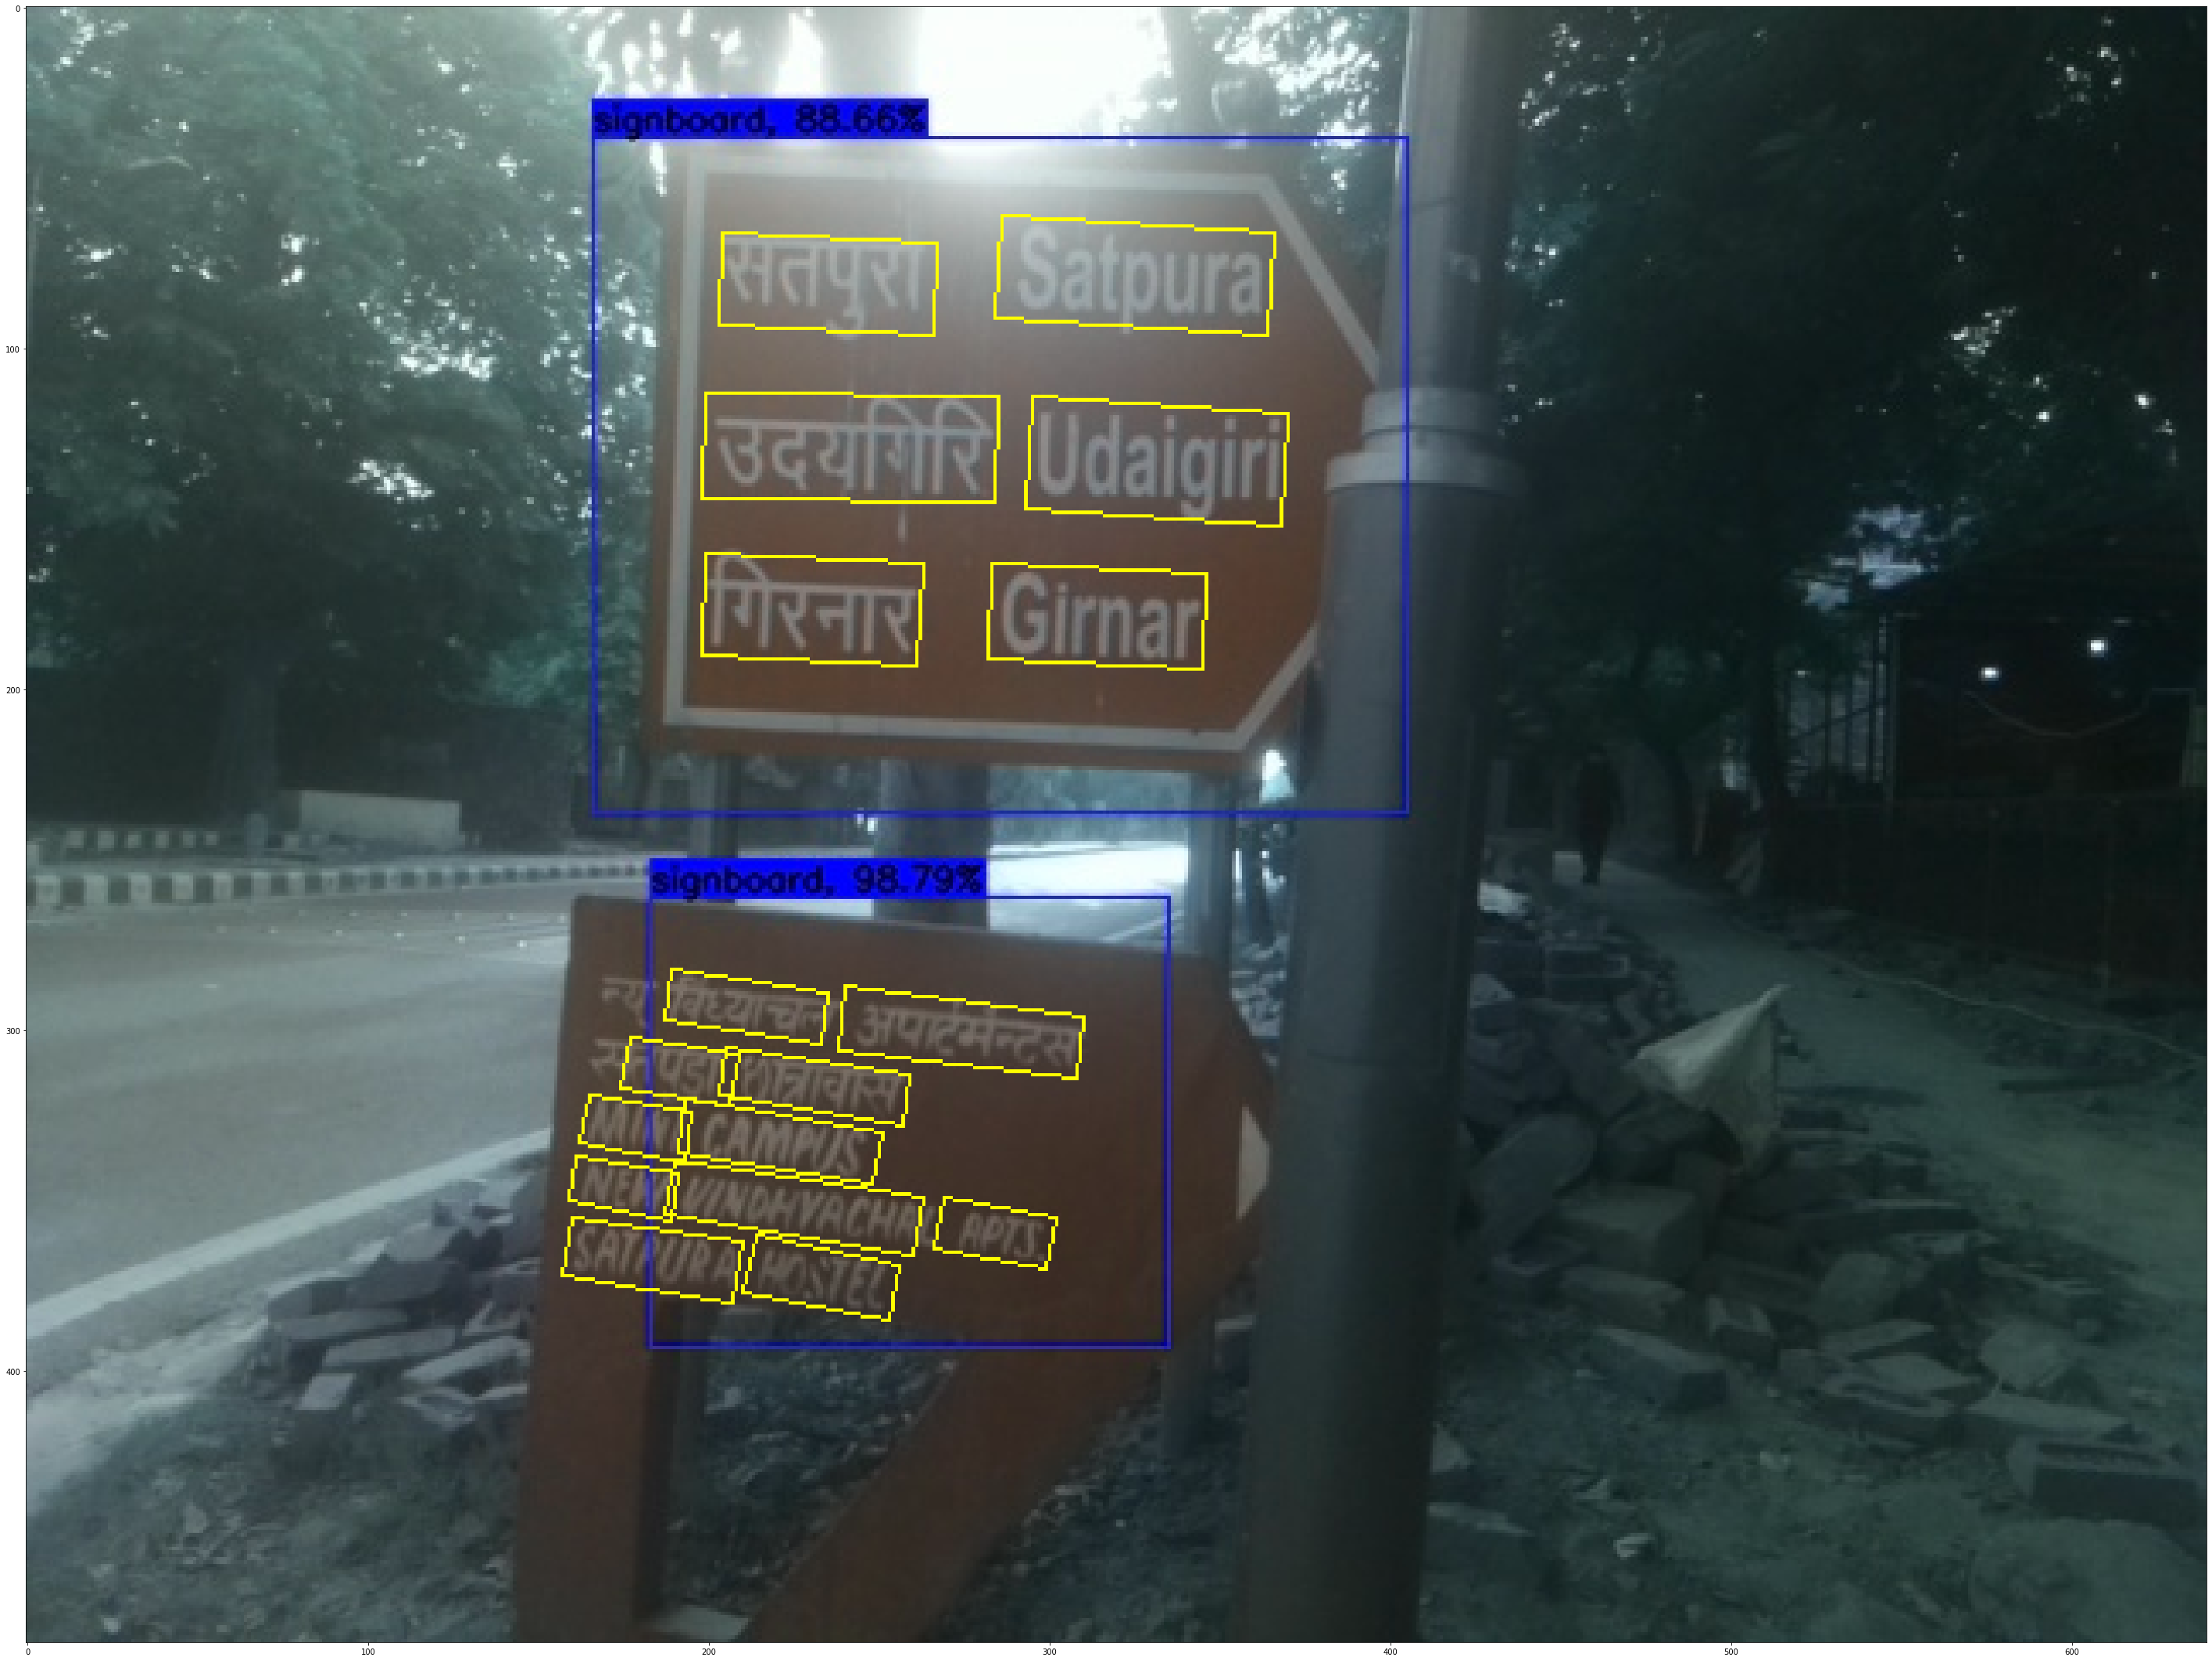

SystemExit: 

In [15]:
#TEST ON IMAGE
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import locality_aware_nms as nms_locality
import lanms
import model
from icdar import restore_rectangle

FLAGS = tf.app.flags.FLAGS

def get_images():
    '''
    find image files in test data path
    :return: list of files found
    '''
    files = []
    exts = ['jpg', 'png', 'jpeg', 'JPG']
    for parent, dirnames, filenames in os.walk(FLAGS.test_data_path):
        for filename in filenames:
            for ext in exts:
                if filename.endswith(ext):
                    print(os.path.join(parent, filename))
                    files.append(os.path.join(parent, filename))
                    break

    print('Found {} images'.format(len(files)))
    return files

def get_image_test():
  '''
  find image files in test data path
  :return: list of files found
  '''
  files = []
  files.append("/home/cse/msr/siy207566/Text_Detection_Assignment/images/945.jpg")
  print('Found {} images'.format(len(files)))
  return files


def resize_image(im, max_side_len=2400):
    '''
    resize image to a size multiple of 32 which is required by the network
    :param im: the resized image
    :param max_side_len: limit of max image size to avoid out of memory in gpu
    :return: the resized image and the resize ratio
    '''
    h, w, _ = im.shape

    resize_w = w
    resize_h = h

    # limit the max side
    if max(resize_h, resize_w) > max_side_len:
        ratio = float(max_side_len) / resize_h if resize_h > resize_w else float(max_side_len) / resize_w
    else:
        ratio = 1.
    resize_h = int(resize_h * ratio)
    resize_w = int(resize_w * ratio)

    resize_h = resize_h if resize_h % 32 == 0 else (resize_h // 32 - 1) * 32
    resize_w = resize_w if resize_w % 32 == 0 else (resize_w // 32 - 1) * 32
    resize_h = max(32, resize_h)
    resize_w = max(32, resize_w)
    im = cv2.resize(im, (int(resize_w), int(resize_h)))

    ratio_h = resize_h / float(h)
    ratio_w = resize_w / float(w)

    return im, (ratio_h, ratio_w)


def detect(score_map, geo_map, timer, score_map_thresh=0.8, box_thresh=0.1, nms_thres=0.2):
    '''
    restore text boxes from score map and geo map
    :param score_map:
    :param geo_map:
    :param timer:
    :param score_map_thresh: threshhold for score map
    :param box_thresh: threshhold for boxes
    :param nms_thres: threshold for nms
    :return:
    '''
    if len(score_map.shape) == 4:
        score_map = score_map[0, :, :, 0]
        geo_map = geo_map[0, :, :, ]
    # filter the score map
    xy_text = np.argwhere(score_map > score_map_thresh)
    # sort the text boxes via the y axis
    xy_text = xy_text[np.argsort(xy_text[:, 0])]
    # restore
    start = time.time()
    text_box_restored = restore_rectangle(xy_text[:, ::-1]*4, geo_map[xy_text[:, 0], xy_text[:, 1], :]) # N*4*2
    print('{} text boxes before nms'.format(text_box_restored.shape[0]))
    boxes = np.zeros((text_box_restored.shape[0], 9), dtype=np.float32)
    boxes[:, :8] = text_box_restored.reshape((-1, 8))
    boxes[:, 8] = score_map[xy_text[:, 0], xy_text[:, 1]]
    timer['restore'] = time.time() - start
    # nms part
    start = time.time()
    # boxes = nms_locality.nms_locality(boxes.astype(np.float64), nms_thres)
    boxes = lanms.merge_quadrangle_n9(boxes.astype('float32'), nms_thres)
    timer['nms'] = time.time() - start

    if boxes.shape[0] == 0:
        return None, timer

    # here we filter some low score boxes by the average score map, this is different from the orginal paper
    for i, box in enumerate(boxes):
        mask = np.zeros_like(score_map, dtype=np.uint8)
        cv2.fillPoly(mask, box[:8].reshape((-1, 4, 2)).astype(np.int32) // 4, 1)
        boxes[i, 8] = cv2.mean(score_map, mask)[0]
    boxes = boxes[boxes[:, 8] > box_thresh]

    return boxes, timer


def sort_poly(p):
    min_axis = np.argmin(np.sum(p, axis=1))
    p = p[[min_axis, (min_axis+1)%4, (min_axis+2)%4, (min_axis+3)%4]]
    if abs(p[0, 0] - p[1, 0]) > abs(p[0, 1] - p[1, 1]):
        return p
    else:
        return p[[0, 3, 2, 1]]


def main(argv=None):
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = FLAGS.gpu_list


    try:
        os.makedirs(FLAGS.output_dir)
    except OSError as e:
        if e.errno != 17:
            raise

    with tf.get_default_graph().as_default():
        input_images = tf.placeholder(tf.float32, shape=[None, None, None, 3], name='input_images')
        global_step = tf.get_variable('global_step', [], initializer=tf.constant_initializer(0), trainable=False)

        f_score, f_geometry = model.model(input_images, is_training=False)

        variable_averages = tf.train.ExponentialMovingAverage(0.997, global_step)
        saver = tf.train.Saver(variable_averages.variables_to_restore())

        with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
            ckpt_state = tf.train.get_checkpoint_state(FLAGS.checkpoint_path)
            model_path = os.path.join(FLAGS.checkpoint_path, os.path.basename(ckpt_state.model_checkpoint_path))
            print('Restore from {}'.format(model_path))
            saver.restore(sess, model_path)

            im_fn_list = get_image_test()
            #images_dict = get_images()
            
            for im_fn in im_fn_list:
                print(im_fn)
                im = cv2.imread(im_fn)[:, :, ::-1]
                start_time = time.time()
                im_resized, (ratio_h, ratio_w) = resize_image(im)

                timer = {'net': 0, 'restore': 0, 'nms': 0}
                start = time.time()
                score, geometry = sess.run([f_score, f_geometry], feed_dict={input_images: [im_resized]})
                timer['net'] = time.time() - start

                boxes, timer = detect(score_map=score, geo_map=geometry, timer=timer)
                print('{} : net {:.0f}ms, restore {:.0f}ms, nms {:.0f}ms'.format(
                    im_fn, timer['net']*1000, timer['restore']*1000, timer['nms']*1000))

                if boxes is not None:
                    boxes = boxes[:, :8].reshape((-1, 4, 2))
                    boxes[:, :, 0] /= ratio_w
                    boxes[:, :, 1] /= ratio_h

                duration = time.time() - start_time
                print('[timing] {}'.format(duration))
                # save to file
                if boxes is not None:
                    res_file = os.path.join(
                        '/home/cse/msr/siy207566/Text_Detection_Assignment',
                        '{}.txt'.format(
                            os.path.basename(im_fn).split('.')[0]))

                with open(res_file, 'w') as f:

                    for box in boxes:
                        # to avoid submitting errors
                        box = sort_poly(box.astype(np.int32))
                        if np.linalg.norm(box[0] - box[1]) < 5 or np.linalg.norm(box[3]-box[0]) < 5:
                            continue
                        f.write('{},{},{},{},{},{},{},{}\r\n'.format(
                            box[0, 0], box[0, 1], box[1, 0], box[1, 1], box[2, 0], box[2, 1], box[3, 0], box[3, 1],
                        ))
                        cv2.polylines(im[:, :, ::-1], [box.astype(np.int32).reshape((-1, 1, 2))], True, color=(255, 255, 0), thickness=1)
                im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
                cv2.imwrite("images/945_out.jpg",im)
                fig, ax = plt.subplots(figsize = (50,100))
                ax.imshow(im)
                plt.show()

if __name__ == '__main__':
    tf.reset_default_graph()
    tf.app.run()

In [ ]:

5 minutes ago99.9 kB
201.jpeg
5 minutes ago121 kB
201.jpg
5 minutes ago121 kB
357.jpg
5 minutes ago95.3 kB
633.jpg
5 minutes ago51.7 kB
77.jpg
5 minutes ago89.5 kB
945.jpg